In [60]:
import numpy as np
import pandas as pd
import sympy as sp

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.integrate import solve_ivp
from scipy.special import expi

from IPython.display import display, Latex

# Task 1

Applying the specified methods, implement algorithms for the numerical solution of a differential equation
$$
    y' = 0.2y + \frac{0.8}{x}
$$
with an initial condition $y(1) = 2$ on an interval $[1,10]$.


In [61]:
# Define IVP properties
def f(x, y):
    return 0.2 * y + 0.8 / x


Y0 = 2.0
START = 1.0
END = 10.0

# Step
def h(M: int):
    return (END - START) / M

DOT_COUNT = 10

### Euler's Method

Consider the initial value problem
$$
    y' = f(x, y), \quad y(x_0)=y_0 .
$$

The linear approximation of $y(t_{n+1})$ using the Euler formula is
$$
    y(x_{n+1}) = y(x_{n})+ h * f(x, y)
$$
where $h = x_{n+1}-x_{n}$.

Therefore, to find the values of the function $y$ at all $x_n$, given $y_0$ and $f(x, y)$, we can START with finding $y(x_1)$ using the Euler’s formula and repeat the process through a for loop for $y(x_2)$, $y(x_3)$, ... 


In [176]:
h_euler = h(25)

X_euler = np.arange(START, END + h_euler, h_euler)
Y_euler = np.zeros(len(X_euler))
Y_euler[0] = Y0

for i in range(len(X_euler) - 1):
    yi = Y_euler[i]
    xi = X_euler[i]
    Y_euler[i + 1] = yi + h_euler * f(xi, yi)  # Euler formula

df = pd.DataFrame({
    "iteration": [i for i in range(0, len(X_euler))],
    "x": X_euler,
    "y": Y_euler
})

styled = (
    df.style
      .format({"x": "{:,.3f}", "y": "{:,.3f}"})
      .hide(axis="index")
)

display(Latex(rf"$h = {h_euler}$"))
# styled

<IPython.core.display.Latex object>

### Runge-Kutta Method

In [63]:
h_rk = h(DOT_COUNT)

X_rk = np.arange(START, END + h_rk, h_rk)
Y_rk = np.zeros(len(X_rk))
Y_rk[0] = Y0

for i in range(len(X_rk) - 1):
    xi = X_rk[i]
    yi = Y_rk[i]

    k1 = f(xi, yi)
    k2 = f(xi + h_rk / 2, yi + h_rk / 2 * k1)
    k3 = f(xi + h_rk / 2, yi + h_rk / 2 * k2)
    k4 = f(xi + h_rk, yi + h_rk * k3)

    Y_rk[i + 1] = yi + h_rk / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

### Adams-Bashforth-Moulton method

In [64]:
h_adam = h(DOT_COUNT)

X_adam = np.arange(START, END + h_adam, h_adam)
Y_adam = np.zeros(len(X_adam))

# We take first four points from the results of Runge-Kutta method
for i in range(0, 4):
    Y_adam[i] = Y_rk[i]

for i in range(3, len(X_adam) - 1):
    xi = X_adam[i]
    yi = Y_adam[i]
    yi1 = Y_adam[i - 1]
    yi2 = Y_adam[i - 2]
    yi3 = Y_adam[i - 3]

    # Adams-Bashforth predictor
    predictor = xi + h_adam / 24 * (-9 * yi3 + 37 * yi2
                                    - 59 * yi1 + 55 * yi)

    prediction = f(X_adam[i + 1], predictor)

    Y_adam[i + 1] = xi + h_adam / 24 * (yi2 - 5 * yi1 + 19 * yi + 9 * prediction)
    

### Cauchy problem solution by `scipy` toolkit

In [65]:
X_exact = np.linspace(START, END, DOT_COUNT)

sol = solve_ivp(
    f, (START, END), [2],
    t_eval=X_exact,
    method="RK45",  # Runga-Kutta method of order 4-5
    rtol=1e-9,
    atol=1e-12
)

Y_exact = sol.y[0]

### Analytical solution (from report)

In [66]:
def y_analytical(x):
    return -4/5 * np.exp(x/5) * expi(-x/5) \
           + ((2 - 4/5 * np.exp(1/5) * expi(-1/5)) / np.exp(1/5)) * np.exp(x/5)


X_analytical = np.linspace(START, END, 400)
Y_analytical = [y_analytical(x) for x in X_analytical]

### Graphical plot of the obtained results

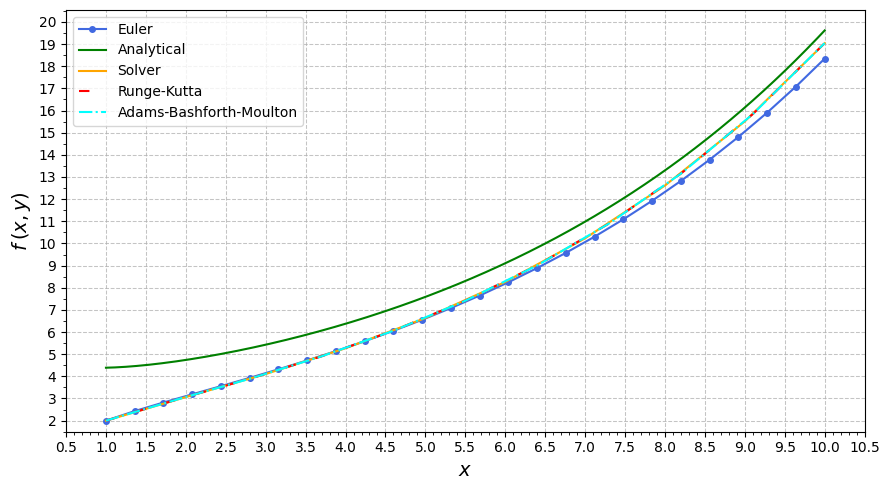

In [76]:
fig, ax = plt.subplots(figsize=(9, 5))

offset = 0.5
ymin = min(Y_euler.min(), Y_exact.min()) - offset
ymax = max(Y_euler.max(), Y_exact.max()) + 3 * offset
ax.set_ylim(ymin, ymax)
ax.set_xlim(START - offset, END + offset)

ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$f\:(x, y)$", fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

# Grid
ax.grid(True, which="major", linestyle="--", linewidth=.75, alpha=.75)

# Curves
ax.plot(
    X_euler, Y_euler,
    color="royalblue",
    marker='o',
    markersize=4,
    label="Euler"
    
)

ax.plot(
    X_analytical, Y_analytical,
    color="green",
    # linestyle="--",
    label="Analytical"
)

ax.plot(
    X_exact, Y_exact,
    color="orange",
    # linestyle="--",
    label="Solver"
)

ax.plot(
    X_rk, Y_rk,
    color="red",
    linestyle=(0, (5, 10)),
    label="Runge-Kutta"
)

ax.plot(
    X_rk, Y_rk,
    color="cyan",
    linestyle='-.',
    label="Adams-Bashforth-Moulton"
)

plt.legend(loc='upper left')
plt.tight_layout()

plt.show()